In [1]:
import numpy as np
import os
import sys
import re
sys.path.append('../')
from symmetry_breaking_measure import InversionOperator, RotationOperator, ReflectionOperator, Perovskite
import matplotlib.pyplot as plt
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from diffpy.structure import Atom, Lattice, Structure, loadStructure
from pymatgen.io.cif import CifParser
import pandas as pd
import copy
from tqdm import tqdm
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import Nickel
from colour import Color
from matplotlib import rc
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

MAX_AMPLITUDE = 20
NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025
BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'

# Data

In [2]:
# Load data
cif_folder = '../examples/glazer_mode_21/'
cif_files = [f for f in os.listdir(cif_folder) if f.endswith('.cif')]
cif_files.sort()
pattern = r"sbm_GM21_(\d+)_"
# Build the dictionary
perovskites_dict = {}
for name in cif_files:
    match = re.search(pattern, name)
    if match:
        key = int(match.group(1))
        p = Perovskite(amplitude=key, cif_directory=cif_folder+name)
        p.expand_by_supercell(num_supercells=1)
        perovskites_dict[key] = p

# Visualization

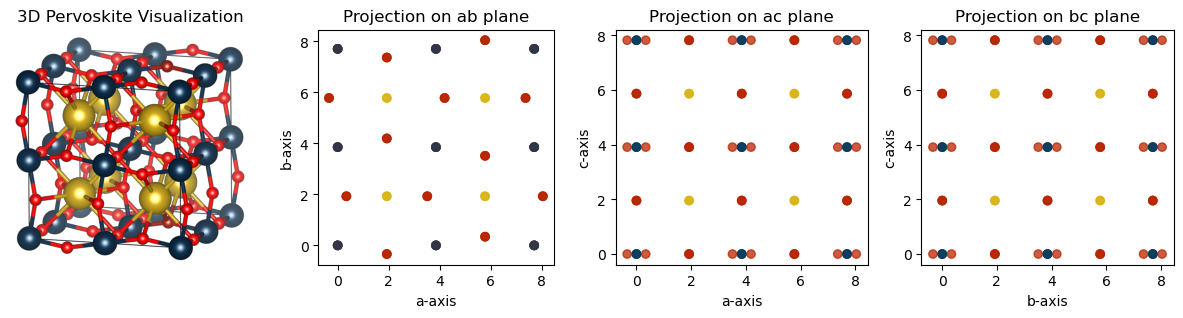

In [3]:
amp = 10
p = perovskites_dict[amp]
# %matplotlib widget
#p.plot_perovskite(plot_3d=True)
p.plot_perovskite(plot_3d_import='../figs/perovskite/perov_10_3d.png', 
                  filename='../figs/perovskite/perov_10.png')

# SBM of Rotation, Reflection, Inversion

original space group 221

4+ 0, y, 0; x, 0, 0; 0, 0, z

m x, y, 0; 0, y, z; x, x, z

1- 0, 0, 0

glazer mode 21 a0a0c+ - space group 127 

4+ 0, 0, z

m x, y, 0

1- 0, 0, 0

In [6]:
def midpoint(r):
    return 0.5 * (r[0] + r[1])

def calc_origin(perov, num_supercells):
    perov.expand_by_supercell(num_supercells=num_supercells)
    x_range, y_range, z_range = perov.calc_range(num_supercells=num_supercells)
    origin = [midpoint(x_range), midpoint(y_range), midpoint(z_range)]
    return origin

def calc_sbm(finite_cluster, operator, method, **operator_kwrgs):
    sample_size, _ = finite_cluster.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=operator,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method=method,
        **operator_kwrgs
    )
    measure = finite_cluster.calc_symmetry_breaking_measure(
        num_samples=sample_size, 
        operator=operator, 
        method=method,
        **operator_kwrgs
    ) 
    return measure

def calc_sbm_4fold_rotation(perov, num_supercells, axis, method):
    origin = calc_origin(perov, num_supercells)
    rotation_op = RotationOperator(axis=axis, origin=origin)
    angles = [90, 180, 270]
    measures = []
    for angle in angles:
        measure = calc_sbm(perov, rotation_op, method, angle=angle)
        measures.append(measure)
    atoms_info_transformed = perov._calc_atoms_info_transformed(operator=rotation_op, atoms_info=perov._atoms_info, angle=90)
    return sum(measures)/len(measures), atoms_info_transformed

def calc_sbm_reflection(perov, num_supercells, axis, method):
    origin = calc_origin(perov, num_supercells)
    reflection_op = ReflectionOperator(axis=axis, origin=origin)
    measure = calc_sbm(perov, reflection_op, method)
    atoms_info_transformed = perov._calc_atoms_info_transformed(operator=reflection_op, atoms_info=perov._atoms_info)
    return measure, atoms_info_transformed

def calc_sbm_inversion(perov, num_supercells, method):
    origin = calc_origin(perov, num_supercells)
    inversion_op = InversionOperator(origin=origin)
    measure = calc_sbm(perov, inversion_op, method)
    atoms_info_transformed = perov._calc_atoms_info_transformed(operator=inversion_op, atoms_info=perov._atoms_info)
    return measure, atoms_info_transformed

In [7]:
# check origins
amp = 10
p = perovskites_dict[amp]
origin = calc_origin(p, num_supercells=1)
check = p._atoms_info
print(origin)

tolerance = 0.01
mask = (check.iloc[:, 0].sub(origin[0]).abs() <= tolerance) & \
       (check.iloc[:, 1].sub(origin[1]).abs() <= tolerance) & \
       (check.iloc[:, 2].sub(origin[2]).abs() <= tolerance)
filtered_rows = check[mask]
print(filtered_rows)

[3.8506000000000005, 3.8506000000000005, 3.91]
         x       y     z  num_electrons      uiso  occupancy
36  3.8506  3.8506  3.91           22.0  0.002699        1.0


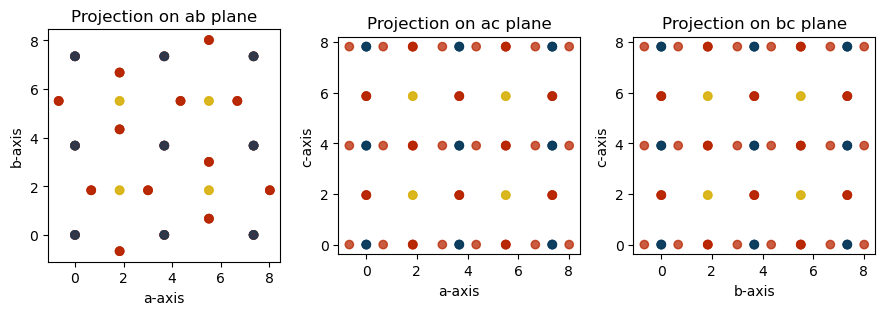

In [8]:
# check transformed atoms_info
amp = 20
p = perovskites_dict[amp]
origin = calc_origin(p, num_supercells=1)
atoms_info = p._atoms_info
atoms_info_transformed = calc_sbm_4fold_rotation(p, num_supercells=1, axis=[0,0,1], method='JS')[1]
p_transformed = copy.deepcopy(p)
p_transformed._atoms_info = atoms_info_transformed
p_transformed.plot_perovskite()

In [ ]:
# check SBM
amp = 10
p = perovskites_dict[amp]
print(calc_sbm_4fold_rotation(p, num_supercells=1, axis=[0,0,1], method='JS')[0])
print(calc_sbm_4fold_rotation(p, num_supercells=1, axis=[0,1,0], method='JS')[0])
print(calc_sbm_4fold_rotation(p, num_supercells=1, axis=[1,0,0], method='JS')[0])

print(calc_sbm_reflection(p, num_supercells=1, axis=[0,0,1], method='JS')[0])
print(calc_sbm_reflection(p, num_supercells=1, axis=[0,1,0], method='JS')[0])
print(calc_sbm_reflection(p, num_supercells=1, axis=[1,0,0], method='JS')[0])

print(calc_sbm_inversion(p, num_supercells=1, method='JS')[0])

# Paper Plots

In [9]:
def sbm_vs_amp(amplitudes:list, num_supercells, op_method, method:str, axis=[]):
    measures = []
    for amp in tqdm(amplitudes):
        perov = perovskites_dict[amp]
        if op_method == 'rotation':
            measures.append(calc_sbm_4fold_rotation(perov, num_supercells, axis, method)[0])
        if op_method == 'reflection':
            measures.append(calc_sbm_reflection(perov, num_supercells, axis, method)[0])
        if op_method == 'inversion':
            measures.append(calc_sbm_inversion(perov, num_supercells, method)[0])
    return measures

def create_line_dict(x, y, linestyle, color):
    return {'x': x, 'y': y, 'linestyle': linestyle, 'color': color}

def plot(data:[dict], xlabel, ylabel, xlim, ylim, filename=None, style=None, text=None):
    fig = plt.figure()
    if style:
        plt.style.use(style)
    fig.set_size_inches(4, 3)
    rc('text', usetex = True) 
    params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
    plt.rcParams.update(params)

    ax_main = fig.add_subplot()
    for d in data:
        ax_main.plot(d['x'], d['y'], linestyle=d['linestyle'], color=d['color'], alpha=0.8)
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(ylim)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    
    if text:
        ax_text = fig.add_axes(text['loc'])
        ax_text.text(0, 0, text['content'])
        ax_text.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)

## SBM v.s. Rotation

In [10]:
AMPLITUDES_RANGE = range(MAX_AMPLITUDE+1)
COLORS = {'100': 'BLUE', '010': 'RED', '001': 'YELLOW'}
LINESTYLES = {'100': '-', '010': '--', '001': '-.'}

measures = {}
for axis in ['100', '010', '001']:
    axis_list = list(map(int, axis))
    measures[axis] = sbm_vs_amp(AMPLITUDES_RANGE, num_supercells=1, op_method='rotation', method='JS', axis=axis_list)

data = [create_line_dict(AMPLITUDES_RANGE, measures[axis], LINESTYLES[axis], COLORS[axis]) for axis in ['100', '010', '001']]

100%|██████████| 21/21 [00:46<00:00,  2.24s/it]


In [11]:
axes = ['100', '010', '001']
for axis in axes:
    filename = f'../figs/perovskite/SBM_rotation_{axis}.csv'
    np.savetxt(filename, [AMPLITUDES_RANGE, measures[axis]], delimiter=',')

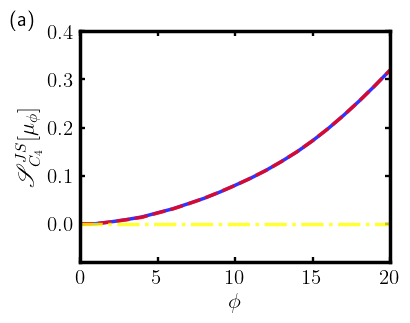

In [12]:
plot(data, xlabel=r'$\phi$', ylabel=r'$\mathscr{S}^{JS}_{C_4}[\mu_{\phi}]$', xlim=[0,20], ylim=[-0.08,.4], 
     filename='../figs/perovskite/SBM_rotation.png', 
     style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.05, .9, 0, 0]}, 
)

## SBM v.s. Reflection

In [13]:
AMPLITUDES_RANGE = range(MAX_AMPLITUDE+1)
COLORS = {'100': 'BLUE', '010': 'RED', '001': 'YELLOW'}
LINESTYLES = {'100': '-', '010': '--', '001': '-.'}

measures = {}
for axis in ['100', '010', '001']:
    axis_list = list(map(int, axis))
    measures[axis] = sbm_vs_amp(AMPLITUDES_RANGE, num_supercells=1, op_method='reflection', method='JS', axis=axis_list)

data = [create_line_dict(AMPLITUDES_RANGE, measures[axis], LINESTYLES[axis], COLORS[axis]) for axis in ['100', '010', '001']]

100%|██████████| 21/21 [00:15<00:00,  1.34it/s]


In [14]:
axes = ['100', '010', '001']
for axis in axes:
    filename = f'../figs/perovskite/SBM_reflection_{axis}.csv'
    np.savetxt(filename, [AMPLITUDES_RANGE, measures[axis]], delimiter=',')

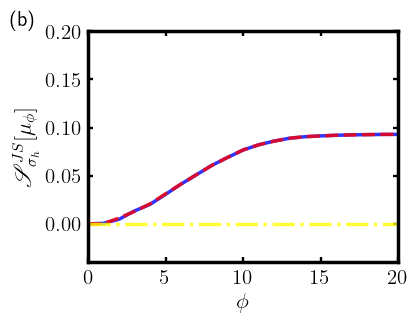

In [15]:
plot(data, xlabel=r'$\phi$', ylabel=r'$\mathscr{S}^{JS}_{\sigma_h}[\mu_{\phi}]$', xlim=[0,20], ylim=[-0.04,0.2], 
     filename='../figs/perovskite/SBM_reflection.png', 
     style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.07, .9, 0, 0]}, 
)

## SBM v.s. Inversion

In [16]:
AMPLITUDES_RANGE = range(MAX_AMPLITUDE+1)
data = [{'x': AMPLITUDES_RANGE,
        'y': sbm_vs_amp(AMPLITUDES_RANGE, num_supercells=1, op_method='inversion', method='JS'), 
        'linestyle': '-.', 
        'color': YELLOW}]
filename = f'../figs/perovskite/SBM_inversion.csv'
np.savetxt(filename, [data[0]['x'], data[0]['y']], delimiter=',')

100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


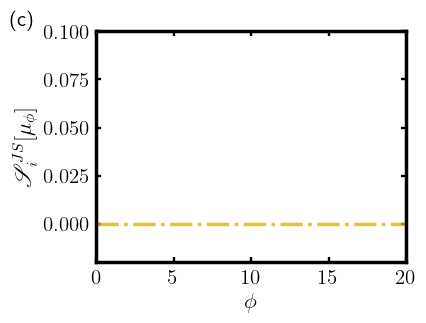

In [17]:
plot(data, xlabel=r'$\phi$', ylabel=r'$\mathscr{S}^{JS}_{i}[\mu_{\phi}]$', xlim=[0,20], ylim=[-0.02,0.1], 
     filename='../figs/perovskite/SBM_inversion.png', 
     style=bg_mpl_style, 
     text={'content':'(c)', 'loc':[-0.09, .9, 0, 0]}, 
)

# Number of atoms in each species

In [ ]:
amp = 10
num_supercells_list = [1, 2, 3, 4, 5, 6, 7]

p = perovskites_dict[amp]
for num in num_supercells_list:
    p.expand_by_supercell(num_supercells=num)
    print(p.calc_num_each_species(), p.calc_num_each_species(ratio=True))
true_ratio = np.array([1,1,4])/6
print('True ratio in crystalline perovksites is {:.2f}:{:.2f}:{:.2f}.'.format(*true_ratio))

## SBM v.s. num_supercells

In [ ]:
AMPLITUDE = 10
NUM_SUPERCELLS_RANGE = range(1, 5)
COLORS = {'100': 'BLUE', '010': 'RED', '001': 'GREEN'}
LINESTYLES = {'100': '-', '010': '--', '001': '-.'}

def sbm_vs_num_supercells(amplitude:int, num_supercells_list:list, axis, method:str):
    measures = []
    perov = perovskites_dict[amplitude]
    for num_supercells in tqdm(num_supercells_list):
        measures.append(calc_sbm_4fold_rotation(perov, num_supercells, axis, method))
    return measures

def get_measures_for_axis(axis, method):
    return sbm_vs_num_supercells(amplitude=AMPLITUDE, num_supercells_list=NUM_SUPERCELLS_RANGE, axis=axis, method=method)

measures = {}
for axis in ['100', '010', '001']:
    axis_list = list(map(int, axis))
    measures[f'KL_{axis}'] = get_measures_for_axis(axis_list, 'KL')
    measures[f'JS_{axis}'] = get_measures_for_axis(axis_list, 'JS')

def create_line_dict(x, y, linestyle, color):
    return {'x': x, 'y': y, 'linestyle': linestyle, 'color': color}

data_KL = [create_line_dict(NUM_SUPERCELLS_RANGE, measures[f'KL_{axis}'], LINESTYLES[axis], COLORS[axis]) for axis in ['100', '010', '001']]
data_JS = [create_line_dict(NUM_SUPERCELLS_RANGE, measures[f'JS_{axis}'], LINESTYLES[axis], COLORS[axis]) for axis in ['100', '010', '001']]

In [63]:
axes = ['100', '010', '001']
methods = ['KL', 'JS']
for axis in axes:
    for method in methods:
        filename = f'../figs/perovskite/SBM_rotation_vs_num_supercell_{axis}_{method}.csv'
        np.savetxt(filename, [NUM_SUPERCELLS_RANGE, measures[f'{method}_{axis}']], delimiter=',')

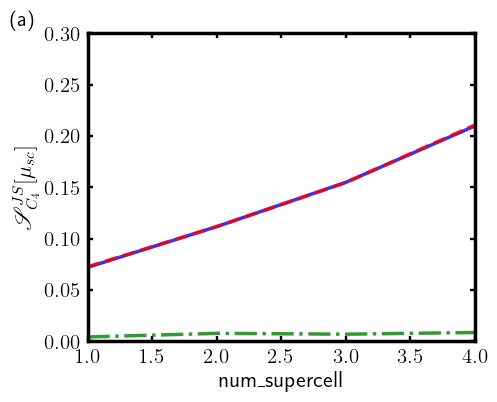

In [73]:
plot(data_JS, xlabel=r'num_supercell', ylabel=r'$\mathscr{S}^{JS}_{C_4}[\mu_{sc}]$', xlim=[1,4], ylim=[0,0.3], 
     filename=None, 
     style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.03, .9, 0, 0]}, 
)

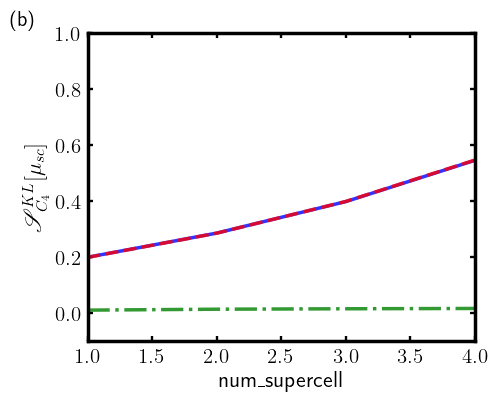

In [74]:
plot(data_KL, xlabel=r'num_supercell', ylabel=r'$\mathscr{S}^{KL}_{C_4}[\mu_{sc}]$', xlim=[1,4], ylim=[-.1,1], 
     filename=None, 
     style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.03, .9, 0, 0]}, 
)